#### Team: Keerthan Ugrani and Shruti Ghargi 
We need a full grading.

### Summary:
This project aims to infer, evaluate, and compare three distinct bi-modal probabilistic models using the Probability Discounting Dataset. Initially, both the given datasets- Probability Discounting Dataset and Delay Discounting Dataset are explored and compared. We think the most suitable dataset is Probability Discounting Dataset. It consists of experimental trials where participants choose between a smaller certain reward and a larger uncertain reward, allowing us to analyze human decision-making under risk.

Each model will predict two key behavioral aspects: (1) participants' choices and (2) reaction times (RTs). While all models will use the Bernoulli Choice Model (Logistic Regression) to model decision-making, they will differ in their approach to RT modeling. Psychological process models are explored to explain variations in response times.

The dataset is divided into training (run A) and testing (run B) phases. Models are trained on run A and evaluated on run B using performance metrics such as accuracy, log loss, and reaction time variance explanation. Separate analyses are conducted for the reward and loss discounting conditions.

After comparing model performances, the best-performing approach is identified based on statistical summaries and graphical visualizations. The final model recommendation is supported by empirical results, predicting both decision-making and cognitive processing speed in probability discounting tasks.

In [1]:
import platform
import psutil
import scipy.stats as stats
import os
import numpy as np
import scipy.io
import pandas as pd
import zipfile
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

In [2]:
def get_cpu_info():
    """Prints basic CPU information."""
    print("CPU:")
    print(platform.processor())

if __name__ == "__main__":
    get_cpu_info()

CPU:
Intel64 Family 6 Model 154 Stepping 3, GenuineIntel


In [3]:
if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available.")

CUDA is not available.


### Exploratory Data Anlysis to understand both the given data

In [4]:
# Define paths
zip_path = "DD_data.zip"
extract_folder = "DD_data/DD_data"
# List .mat files in the extracted folder
mat_files = [f for f in os.listdir(extract_folder) if f.endswith('.mat')]

# # Debugging output
# print("MAT files found:", mat_files)

if not mat_files:
    raise FileNotFoundError("No .mat files found in the extracted folder. Check the ZIP file and extraction process.")

In [5]:
column_names = [
    "immOutcome_immediate_choice_reward",    # Immediate Reward
    "delOutcome_delayed_choice_reward",    # Delayed Reward
    "delay",   # Delay Time
    "choice",  # Choice (1 = Immediate, 2 = Delayed, 0 = Missing)
    "p_imm",   # Probability Immediate (Experimental Conditions)
    "condition", # Condition (1 = Reward Discounting, 2 = Loss Discounting)
    "RT"       # Reaction Time
]

In [6]:
# Process each .mat file
dataframes = {}
for file in mat_files:
    file_path = os.path.join(extract_folder, file)
    
    # Load MATLAB file
    mat_data = scipy.io.loadmat(file_path)

    # Extract train, test, and labels
    train_data = pd.DataFrame(mat_data["data_train"], columns=column_names)
    test_data = pd.DataFrame(mat_data["data_test"], columns=column_names)
    labels = list(mat_data["data_labels"].flatten())  # Convert label array to list

    # Store in dictionary
    dataframes[file] = {
        "train": train_data,
        "test": test_data,
        "labels": labels
    }

In [7]:
# Display dataset shapes
print(f"Train Shape: {train_data.shape}, Test Shape: {test_data.shape}")

Train Shape: (100, 7), Test Shape: (225, 7)


In [8]:
print("Train Data Statistics:\n", train_data.describe())
print("\nTest Data Statistics:\n", test_data.describe())

Train Data Statistics:
        immOutcome_immediate_choice_reward  delOutcome_delayed_choice_reward  \
count                          100.000000                        100.000000   
mean                            23.186900                         37.000000   
std                             29.998919                         35.333905   
min                              0.020000                          5.000000   
25%                              3.335000                         10.000000   
50%                              9.820000                         20.000000   
75%                             35.940000                         50.000000   
max                             99.990000                        100.000000   

           delay      choice  p_imm  condition           RT  
count  100.00000  100.000000  100.0      100.0   100.000000  
mean   134.40000    1.350000    0.5        1.0  1339.750000  
std    130.54447    0.479372    0.0        0.0   385.084183  
min      7.00000

In [9]:
#Check for missing values
print("Missing values in Train Data:\n", train_data.isnull().sum())
print("\n Missing values in Test Data:\n", test_data.isnull().sum())

Missing values in Train Data:
 immOutcome_immediate_choice_reward    0
delOutcome_delayed_choice_reward      0
delay                                 0
choice                                0
p_imm                                 0
condition                             0
RT                                    0
dtype: int64

 Missing values in Test Data:
 immOutcome_immediate_choice_reward    0
delOutcome_delayed_choice_reward      0
delay                                 0
choice                                0
p_imm                                 0
condition                             0
RT                                    0
dtype: int64


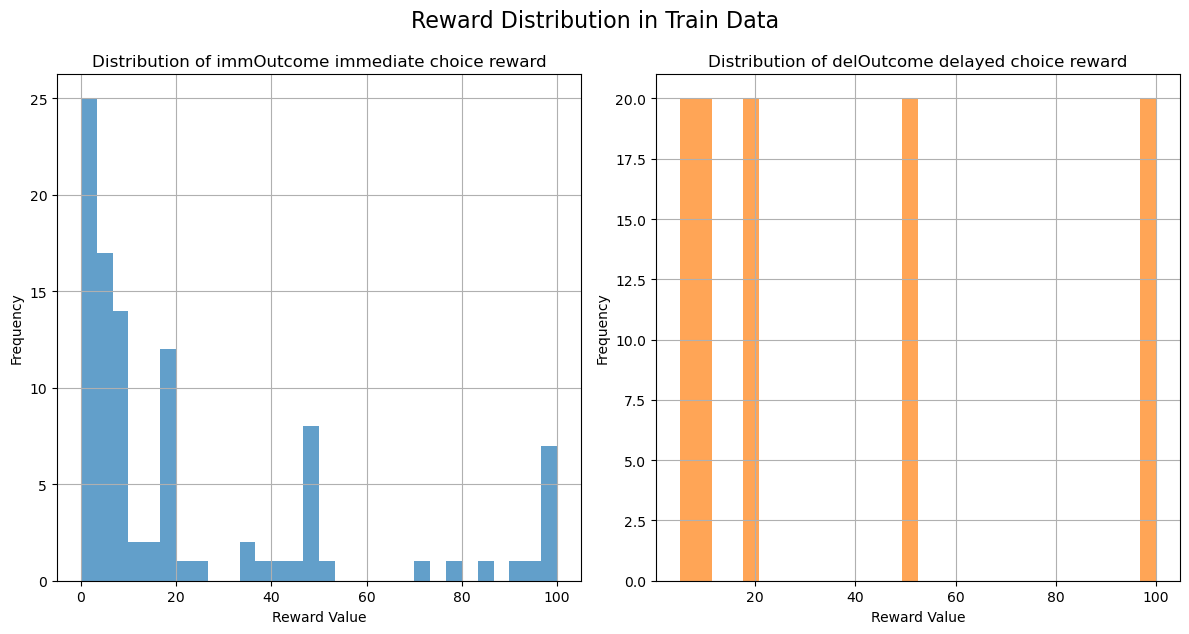

In [10]:
#Distribution of Immediate vs Delayed rewards - Histogram plot
# Select reward columns
reward_cols = ["immOutcome_immediate_choice_reward", "delOutcome_delayed_choice_reward"]

# Plot histograms separately
plt.figure(figsize=(12, 6))

for i, col in enumerate(reward_cols):
    plt.subplot(1, 2, i + 1)  # Create subplots for better visualization
    train_data[col].hist(bins=30, color=["#1f77b4", "#ff7f0e"][i], alpha=0.7)
    plt.title(f"Distribution of {col.replace('_', ' ')}")
    plt.xlabel("Reward Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.suptitle("Reward Distribution in Train Data", fontsize=16, y=1.05)
plt.show()

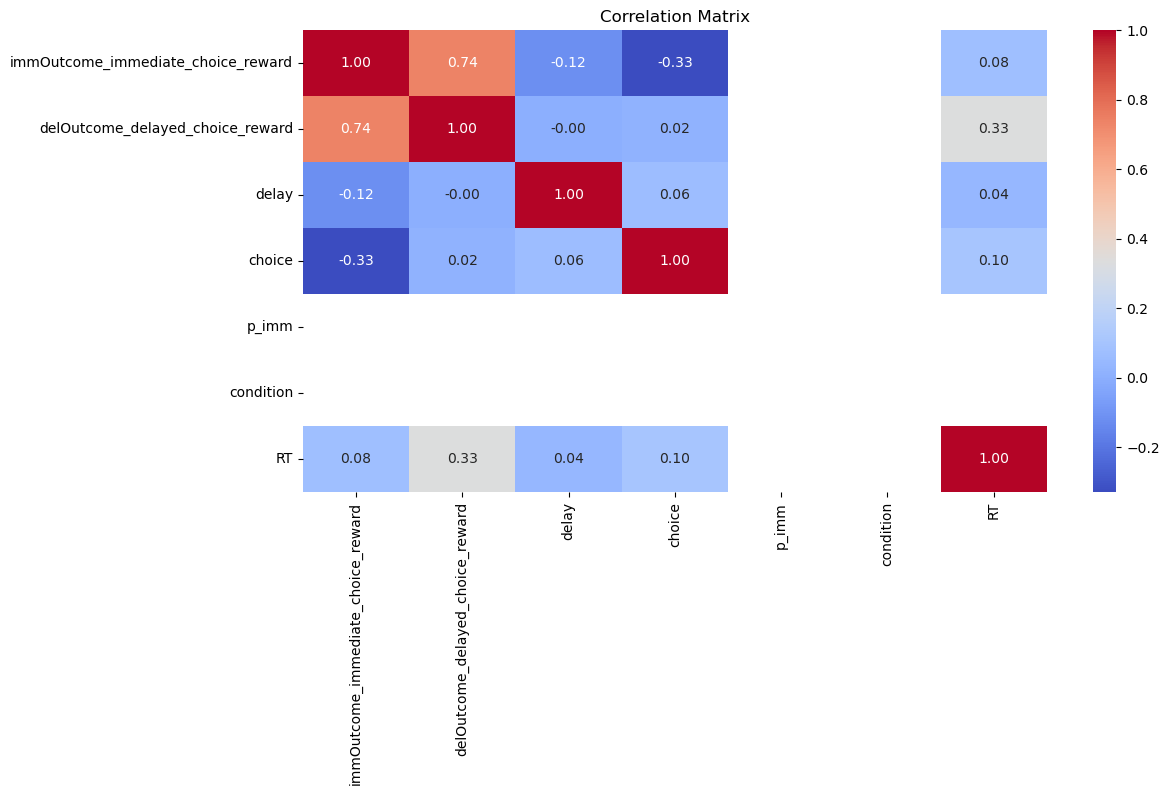

In [11]:
# Plot correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(train_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

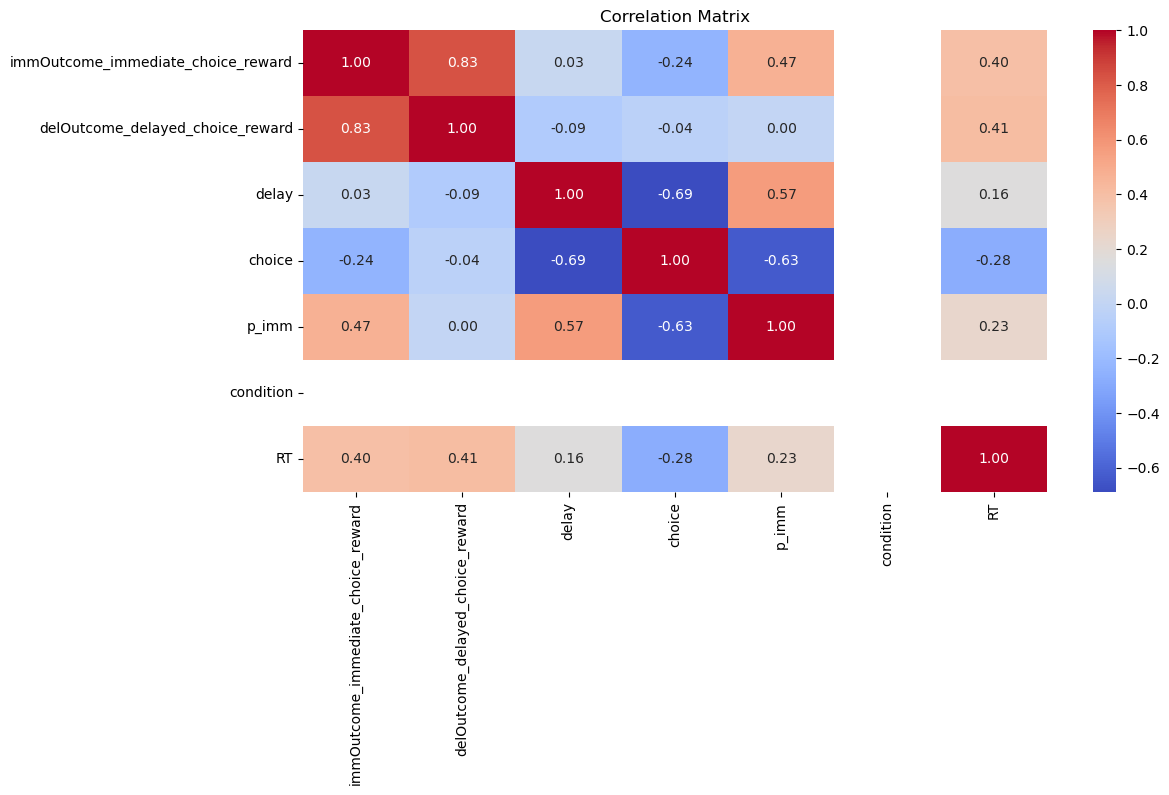

In [12]:
# Plot correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(test_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

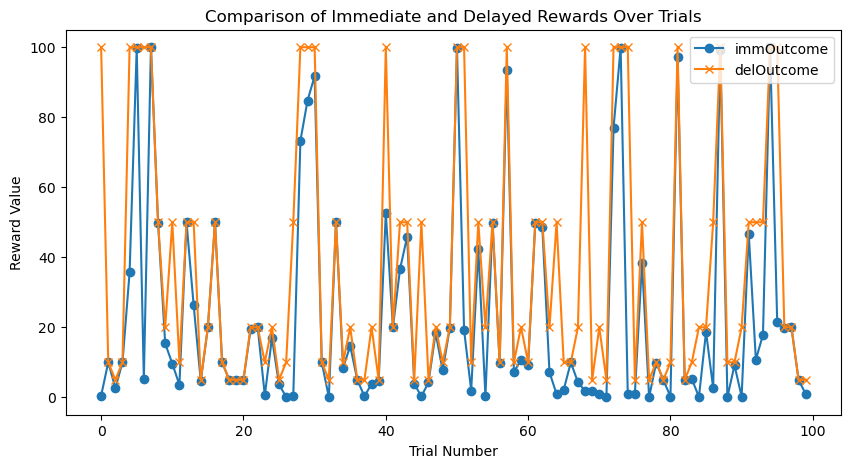

In [13]:
#Compare immediate vs Delayed rewards
plt.figure(figsize=(10, 5))
immediate_rewards = train_data['immOutcome_immediate_choice_reward']
delayed_rewards = train_data['delOutcome_delayed_choice_reward']

plt.plot(immediate_rewards, label="immOutcome", marker="o")
plt.plot(delayed_rewards, label="delOutcome", marker="x")
plt.xlabel("Trial Number")
plt.ylabel("Reward Value")
plt.legend()
plt.title("Comparison of Immediate and Delayed Rewards Over Trials")
plt.show()


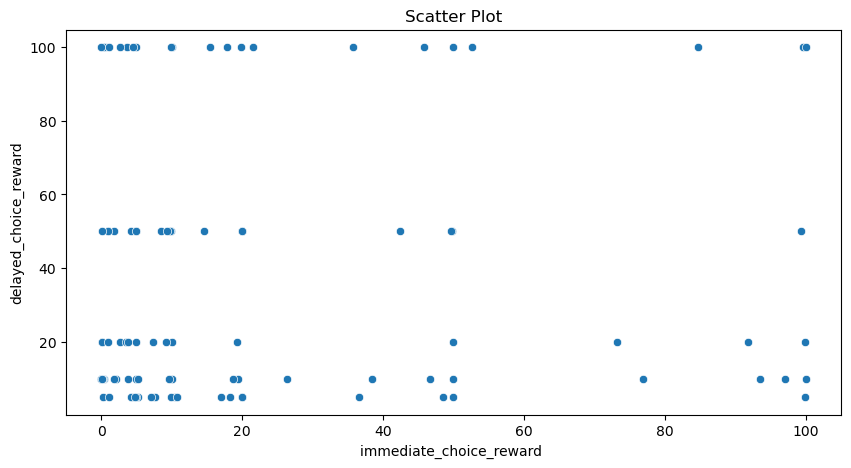

In [14]:
# Scatter Plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x=train_data['immOutcome_immediate_choice_reward'], y=test_data['delOutcome_delayed_choice_reward'])
plt.xlabel('immediate_choice_reward ')
plt.ylabel('delayed_choice_reward')
plt.title('Scatter Plot')
plt.show()

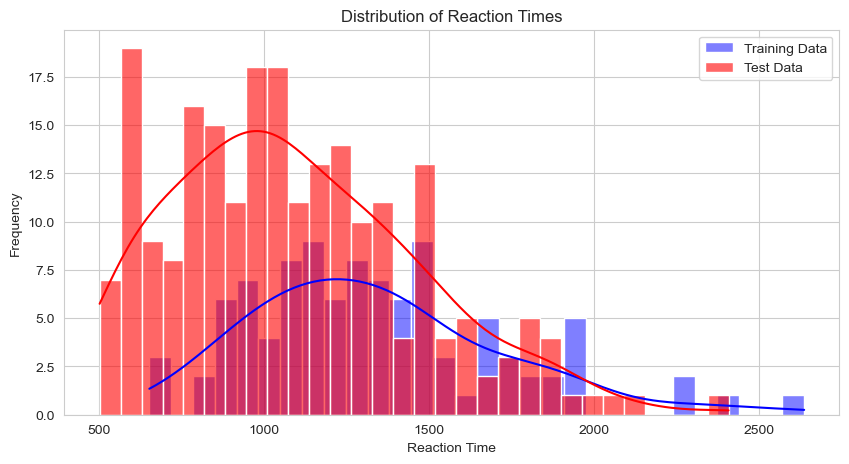

In [15]:
# Histogram visualization of Reaction time distributions
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(train_data['RT'].dropna(), bins=30, kde=True, color='blue', label='Training Data')
sns.histplot(test_data['RT'].dropna(), bins=30, kde=True, color='red', label='Test Data', alpha=0.6)
plt.xlabel('Reaction Time')
plt.ylabel('Frequency')
plt.title('Distribution of Reaction Times')
plt.legend()
plt.show()

In [16]:
extract_folder = "PD_data/PD_data"

mat_files = [os.path.join(extract_folder, f) for f in os.listdir(extract_folder) if f.endswith(".mat")]

all_data_train = []
all_data_test = []

for file in mat_files:
    mat_contents = scipy.io.loadmat(file)
    
    # Extract column labels
    data_labels = [label[0] for label in mat_contents["data_labels"].flatten()]
    
    # Convert data_train and data_test to DataFrames
    train_df = pd.DataFrame(mat_contents["data_train"], columns=data_labels)
    test_df = pd.DataFrame(mat_contents["data_test"], columns=data_labels)
    
    # Add participant ID
    participant_id = os.path.basename(file).replace(".mat", "")
    train_df["participant_id"] = participant_id
    test_df["participant_id"] = participant_id
    
    # Append to lists
    all_data_train.append(train_df)
    all_data_test.append(test_df)

# Combine all participants' data
full_data_train_df = pd.concat(all_data_train, ignore_index=True)
full_data_test_df = pd.concat(all_data_test, ignore_index=True)

In [17]:
# Exclude non-numeric columns before correlation analysis
numeric_train_df = full_data_train_df.select_dtypes(include=[np.number])
numeric_test_df = full_data_test_df.select_dtypes(include=[np.number])

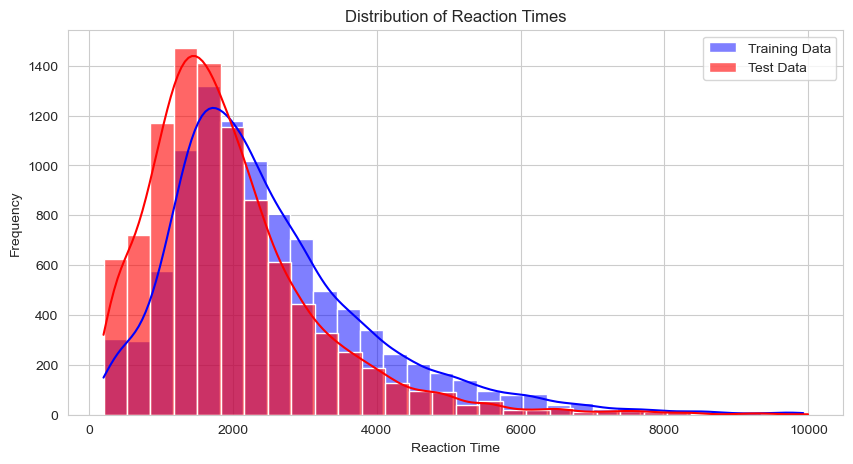

In [18]:
# Visualization
sns.set_style("whitegrid")

# Histogram of Reaction Times
plt.figure(figsize=(10, 5))
sns.histplot(full_data_train_df['RT'].dropna(), bins=30, kde=True, color='blue', label='Training Data')
sns.histplot(full_data_test_df['RT'].dropna(), bins=30, kde=True, color='red', label='Test Data', alpha=0.6)
plt.xlabel('Reaction Time')
plt.ylabel('Frequency')
plt.title('Distribution of Reaction Times')
plt.legend()
plt.show()

- The histogram shows the distribution of reaction times for both training (blue) and test (red) datasets.
- The distribution is right-skewed, meaning that most decisions are made quickly, but some trials have significantly longer RTs.
- Most participants respond within a certain range, but a few trials involve much longer deliberation times.

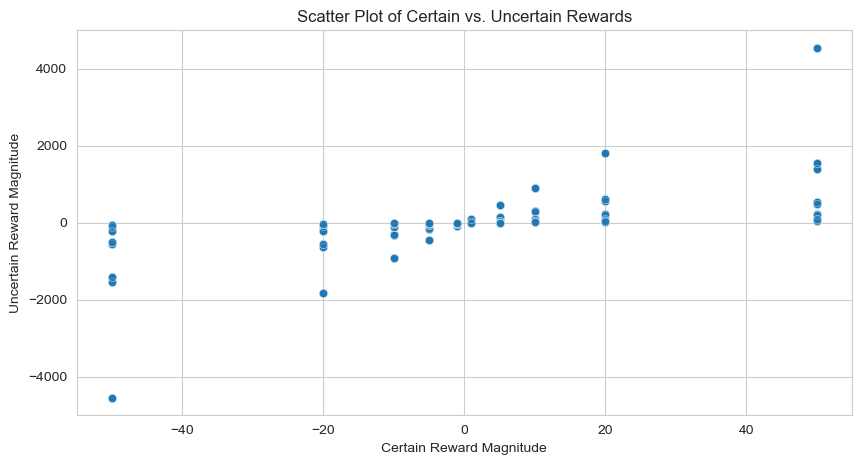

In [19]:
# Scatter Plot: Certain vs. Uncertain Reward Magnitudes
plt.figure(figsize=(10, 5))
sns.scatterplot(x=full_data_train_df['certOutcome'], y=full_data_train_df['uncOutcome'], alpha=0.5)
plt.xlabel('Certain Reward Magnitude')
plt.ylabel('Uncertain Reward Magnitude')
plt.title('Scatter Plot of Certain vs. Uncertain Rewards')
plt.show()

- The spread of the points suggests a range of risk-taking behaviors among participants.
- A clear clustering pattern may indicate that participants were exposed to a few fixed experimental conditions.

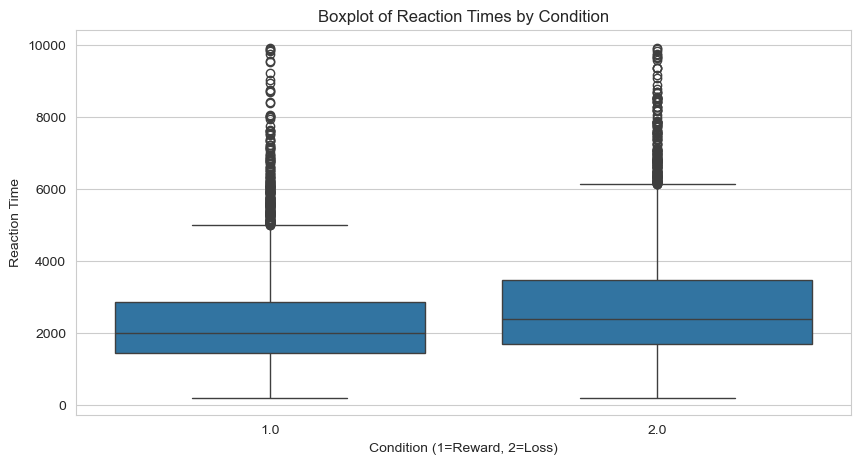

In [20]:
# Boxplot of Reaction Times by Condition
plt.figure(figsize=(10, 5))
sns.boxplot(x=full_data_train_df['condition (1=reward,2=loss)'], y=full_data_train_df['RT'])
plt.xlabel('Condition (1=Reward, 2=Loss)')
plt.ylabel('Reaction Time')
plt.title('Boxplot of Reaction Times by Condition')
plt.show()

- This visualization compares RT distributions for reward-based vs. loss-based decision-making conditions.
- If the median RTs are higher for one condition, it suggests that participants took more time to deliberate.
- The presence of outliers in either condition may indicate difficult trials where participants took longer to decide.
- If reward discounting has a higher median RT, it might indicate more careful deliberation in reward-seeking behavior
- If loss discounting has a higher median RT, it suggests that participants hesitate more when making loss-related decisions.

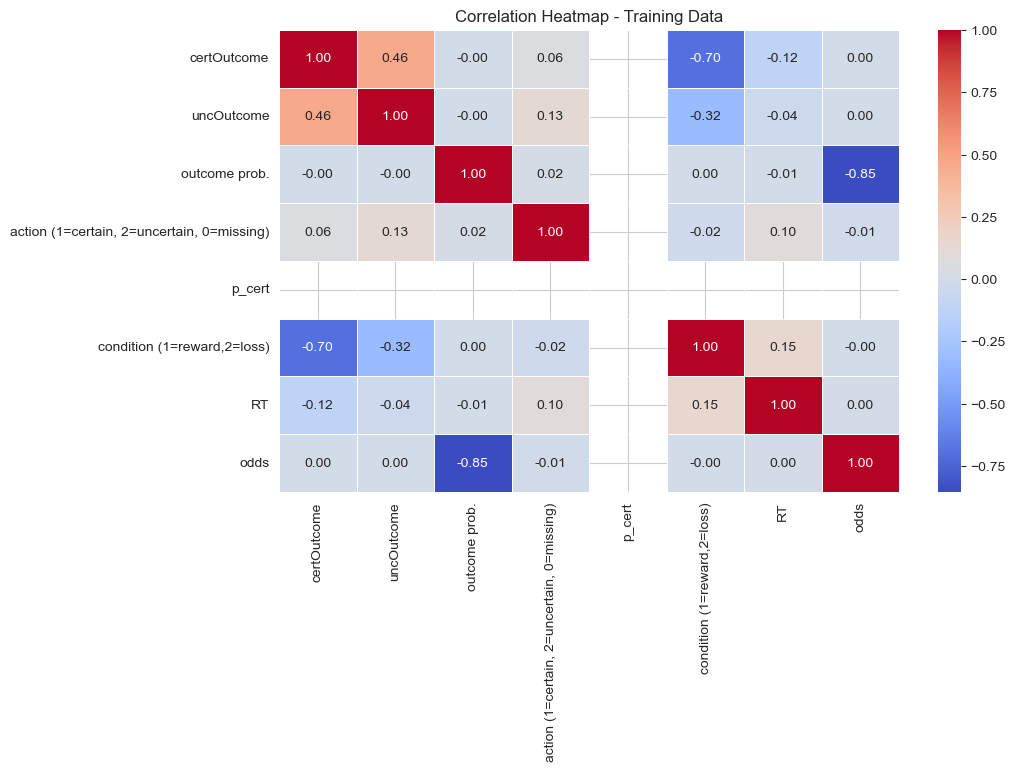

In [21]:
# Correlation Heatmap for Training Data
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_train_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap - Training Data')
plt.show()

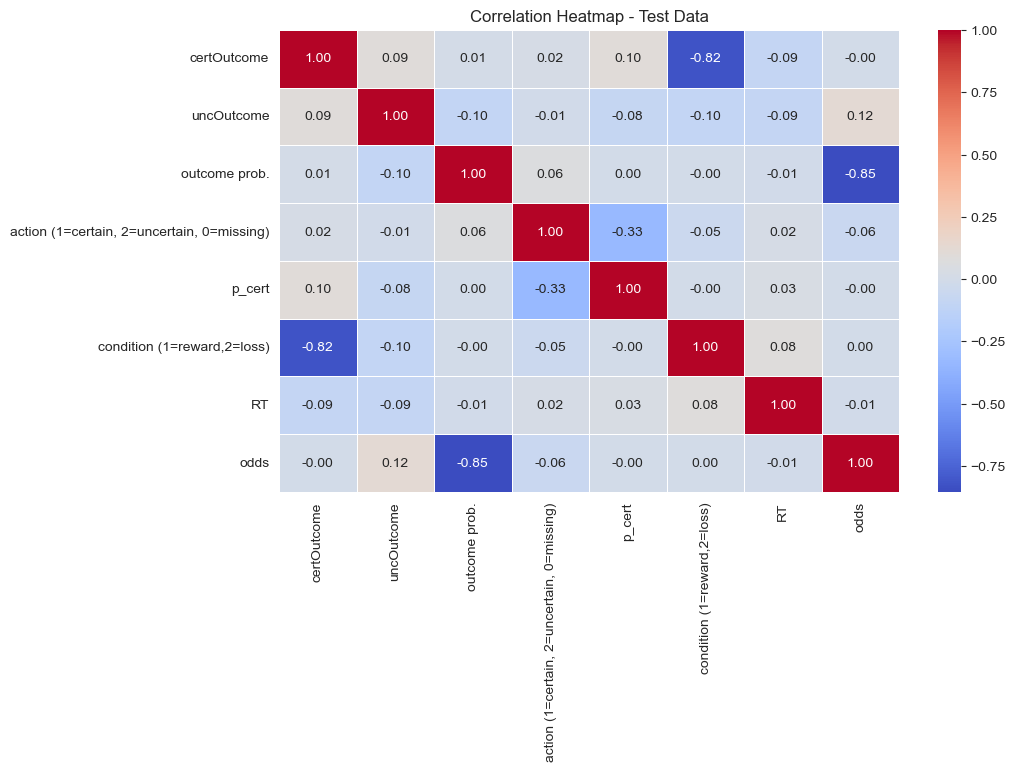

In [22]:
# Correlation Heatmap for Test Data
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_test_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap - Test Data')
plt.show()

The Bernoulli's choice model assumes binary probabilistic decisions where variability in reaction times reflects differences in uncertainty or evidence accumulation.

The delay discounting data’s narrower range of reaction times and lower skewness suggest that choices are not driven by probabilistic reasoning but rather by individual preferences or heuristics. This makes it less suitable for the Bernoulli's choice model.

In [23]:
print(numeric_train_df)
print(numeric_test_df)

      certOutcome  uncOutcome  outcome prob.  \
0            -1.0       -1.30           25.0   
1           -20.0     -200.00           25.0   
2           -50.0    -1550.00           25.0   
3           -10.0      -21.11           90.0   
4            -1.0       -1.01           90.0   
...           ...         ...            ...   
9795        -10.0      -13.33           90.0   
9796        -20.0      -40.00           50.0   
9797         -5.0       -6.67           75.0   
9798         -1.0      -10.00           10.0   
9799        -20.0      -38.00           10.0   

      action (1=certain, 2=uncertain, 0=missing)  p_cert  \
0                                            2.0     NaN   
1                                            1.0     NaN   
2                                            1.0     NaN   
3                                            1.0     NaN   
4                                            2.0     NaN   
...                                          ...     ...   
979

In [24]:
# Define Bernoulli Choice Model
def fit_bernoulli_choice_model(X, y):
    model = LogisticRegression()
    model.fit(X, y)
    return model

# Prepare data for choice modeling
X_train = numeric_train_df[["certOutcome", "uncOutcome", "outcome prob."]]
y_train = numeric_train_df["action (1=certain, 2=uncertain, 0=missing)"].replace(1, 2) 
X_test = numeric_test_df[["certOutcome", "uncOutcome", "outcome prob."]]
y_test = numeric_test_df["action (1=certain, 2=uncertain, 0=missing)"].replace(1, 2)

# Fit Bernoulli choice model
bernoulli_model = fit_bernoulli_choice_model(X_train, y_train)

# Validate the Bernoulli model
accuracy = bernoulli_model.score(X_test, y_test)
print(f"Bernoulli Model Accuracy on Validation Data: {accuracy}")

Bernoulli Model Accuracy on Validation Data: 0.9818367346938776


When we consider to predict only one of the choices of the participants (either only certain or only uncertain choice) then the accuracy of prediction of the probability is 98%

In [25]:
# Define Bernoulli Choice Model
def fit_bernoulli_choice_model(X, y):
    model = LogisticRegression()
    model.fit(X, y)
    return model

# Prepare data for choice modeling
X_train = numeric_train_df[["certOutcome", "uncOutcome", "outcome prob."]]
y_train = numeric_train_df["action (1=certain, 2=uncertain, 0=missing)"].replace(2, 0) 
X_test = numeric_test_df[["certOutcome", "uncOutcome", "outcome prob."]]
y_test = numeric_test_df["action (1=certain, 2=uncertain, 0=missing)"].replace(2, 0)

# Fit Bernoulli choice model
bernoulli_model = fit_bernoulli_choice_model(X_train, y_train)

# Validate the Bernoulli model
accuracy = bernoulli_model.score(X_test, y_test)
print(f"Bernoulli Model Accuracy on Validation Data: {accuracy}")

Bernoulli Model Accuracy on Validation Data: 0.5055102040816326


When we consider to predict either of the choices of the participants (certain and uncertain choice) then the accuracy of prediction of the probability is 50.5%

[I 2025-03-03 01:01:53,213] A new study created in memory with name: no-name-a534b525-f357-4798-8245-1d4123ec54b7
[I 2025-03-03 01:01:53,222] Trial 0 finished with value: 89077.50567801572 and parameters: {'tau': 0.31952661451376174, 'mu': 7.16826330322348, 'sigma': 1.5218530513134054}. Best is trial 0 with value: 89077.50567801572.
[I 2025-03-03 01:01:53,228] Trial 1 finished with value: 85353.83101700243 and parameters: {'tau': 0.6110067878712575, 'mu': 7.6976495910976395, 'sigma': 0.9822257371909044}. Best is trial 1 with value: 85353.83101700243.
[I 2025-03-03 01:01:53,233] Trial 2 finished with value: 103450.4123655576 and parameters: {'tau': 0.962458686431128, 'mu': 6.89026135530787, 'sigma': 0.4047316457118537}. Best is trial 1 with value: 85353.83101700243.
[I 2025-03-03 01:01:53,239] Trial 3 finished with value: 85757.8746213969 and parameters: {'tau': 0.1476384901456378, 'mu': 7.829733184770802, 'sigma': 0.4269103024092108}. Best is trial 1 with value: 85353.83101700243.
[I 2

Final Model Comparison Table:
                    Log-Likelihood            AIC            BIC
Shifted Log-Normal   -83674.264238  167354.528476  167376.083236
Weibull              -91508.686039  183021.372079  183035.741919
Shifted Weibull      -90949.648052  181905.296105  181926.850865


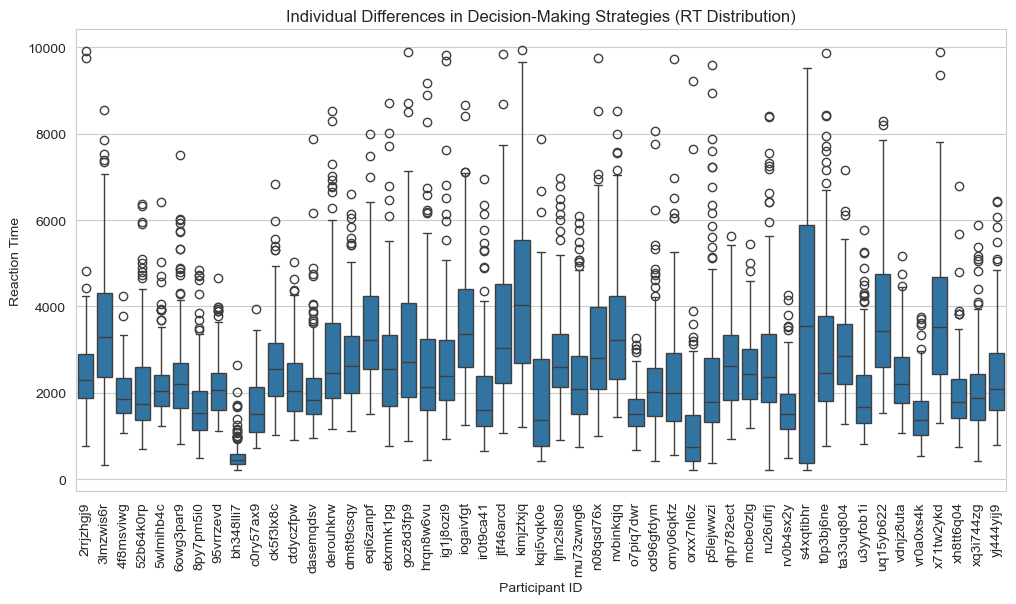

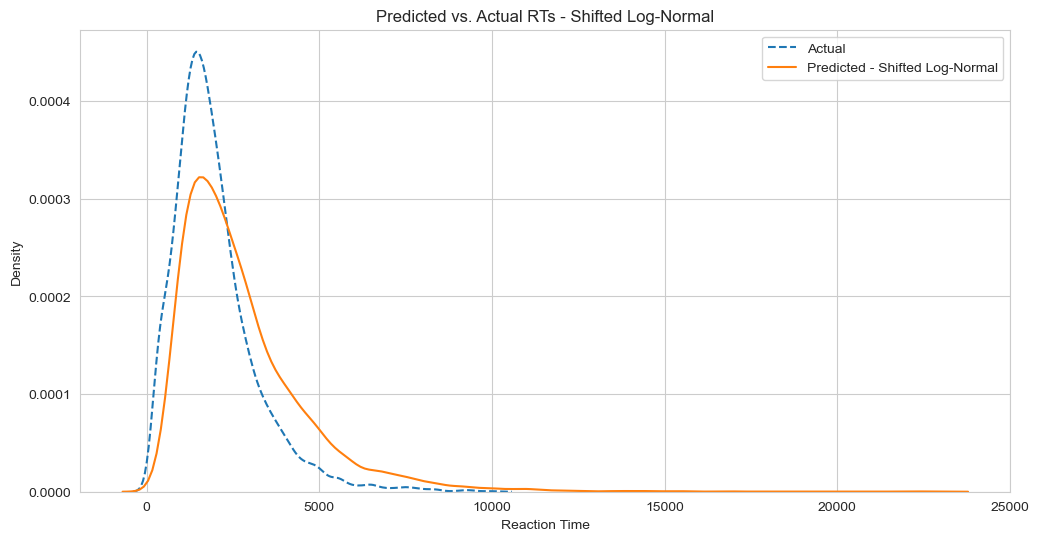

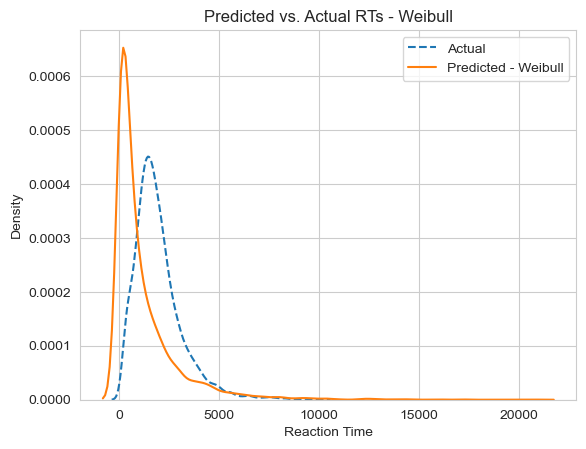

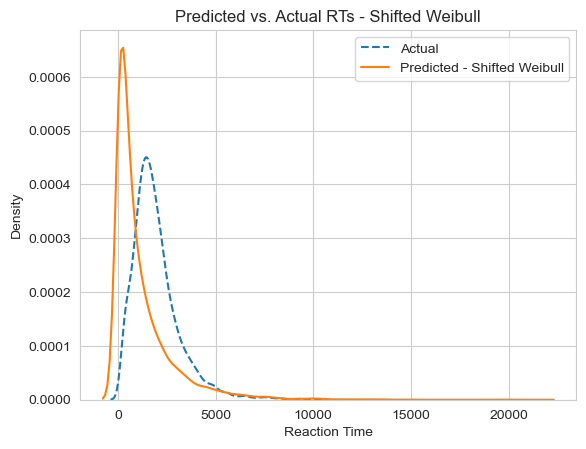

In [26]:
# Define Reaction Time Models
def shifted_lognormal_mle(params, rt):
    tau, mu, sigma = params
    rt_shifted = rt - tau
    rt_shifted = np.maximum(rt_shifted, 1e-6)
    return -np.sum(np.log(stats.lognorm.pdf(rt_shifted, s=sigma, scale=np.exp(mu)) + 1e-10))

def weibull_mle(params, rt):
    k, lambda_ = params
    return -np.sum(np.log(stats.weibull_min.pdf(rt, k, scale=lambda_) + 1e-10))

def shifted_weibull_mle(params, rt):
    k, lambda_, tau = params
    rt_shifted = rt - tau
    rt_shifted = np.maximum(rt_shifted, 1e-6)
    return -np.sum(np.log(stats.weibull_min.pdf(rt_shifted, k, scale=lambda_) + 1e-10))

# Fit Models on Training Data
rt_train = numeric_train_df["RT"].dropna()
rt_test = numeric_test_df["RT"].dropna()

# Optuna Optimization
models = ["Shifted Log-Normal", "Weibull", "Shifted Weibull"]
best_params = {}

def optimize_model(trial, model_name):
    if model_name == "Shifted Log-Normal":
        return shifted_lognormal_mle([trial.suggest_float("tau", 0.01, 1.0),
                                       trial.suggest_float("mu", np.log(np.mean(rt_train)) - 1, np.log(np.mean(rt_train)) + 1),
                                       trial.suggest_float("sigma", 0.1, 2.0)], rt_train)
    elif model_name == "Weibull":
        return weibull_mle([trial.suggest_float("k", 0.1, 5.0), trial.suggest_float("lambda_", 100, 1000)], rt_train)
    elif model_name == "Shifted Weibull":
        return shifted_weibull_mle([trial.suggest_float("k", 0.1, 5.0), trial.suggest_float("lambda_", 100, 1000), trial.suggest_float("tau", 0.01, 1.0)], rt_train)

for model in models:
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: optimize_model(trial, model), n_trials=50)
    best_params[model] = study.best_params

# Compute model comparison metrics
model_comparison = {}
predicted_rts = {}

for model, params in best_params.items():
    log_likelihood = -optimize_model(optuna.trial.FixedTrial(params), model)
    k = len(params)
    aic = 2 * k - 2 * log_likelihood
    bic = k * np.log(len(rt_train)) - 2 * log_likelihood
    model_comparison[model] = {"Log-Likelihood": log_likelihood, "AIC": aic, "BIC": bic}
    
    if model == "Shifted Log-Normal":
        predicted_rts[model] = stats.lognorm.rvs(s=params["sigma"], scale=np.exp(params["mu"]), size=len(rt_test)) + params["tau"]
    elif model == "Weibull":
        predicted_rts[model] = stats.weibull_min.rvs(c=params["k"], scale=params["lambda_"], size=len(rt_test))
    elif model == "Shifted Weibull":
        predicted_rts[model] = stats.weibull_min.rvs(c=params["k"], scale=params["lambda_"], size=len(rt_test)) + params["tau"]

# Convert to DataFrame
model_comparison_df = pd.DataFrame.from_dict(model_comparison, orient='index')
print("Final Model Comparison Table:")
print(model_comparison_df)

# Analyze Individual Differences in Decision-Making Strategies
plt.figure(figsize=(12, 6))
sns.boxplot(x=full_data_train_df["participant_id"], y=full_data_train_df["RT"])
plt.xticks(rotation=90)
plt.xlabel("Participant ID")
plt.ylabel("Reaction Time")
plt.title("Individual Differences in Decision-Making Strategies (RT Distribution)")
plt.show()

# Plot predicted vs. actual RTs
plt.figure(figsize=(12, 6))
for model, preds in predicted_rts.items():
    sns.kdeplot(rt_test, label="Actual", linestyle="--")
    sns.kdeplot(preds, label=f"Predicted - {model}")
    plt.title(f"Predicted vs. Actual RTs - {model}")
    plt.xlabel("Reaction Time")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


Among the three RT models evaluated, the Shifted Log-Normal model emerged as the best candidate. This model accurately captures both the peak and long-tail variability of the observed RTs, outperforming the Weibull and shifted Weibull models in fitting the empirical data.
